In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import lettuce as lt
from lettuce import D2Q9, Lattice, UnitConversion, BGKCollision, StandardStreaming, Simulation, IncompressibleKineticEnergy, WallQuantities
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import csv

In [2]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="/home/ben/Schreibtisch/channel")
parser.add_argument("--h", type=int, default=100)
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=100)
parser.add_argument("--tmax", type=int, default=0)
parser.add_argument("--Re", type=int, default=10000)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="Double")
parser.add_argument("--Mach", type=float, default=0.05)
args, unknown = parser.parse_known_args()
args = vars(args)
print("ICH FUNKTIONIERE MIT PULLEN")
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision= args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
h = args["h"]
res_y = 2 * h                     # y: volle Kanalhöhe
res_x = int(2*np.pi * h)

acceleration = np.array([1e-7, 0.0])  # Body Force in x-Richtung (Guo)


if Precision == "Single":
    dtype = torch.float32
elif Precision == "Double":
    dtype = torch.float64
elif Precision == "Half":
    dtype = torch.float16

ICH FUNKTIONIERE MIT PULLEN


steps     time     IncompressibleKineticEnergy
steps     time     WallQuantities
tensor([[[ 1.6209e-02,  8.5919e-03, -4.3064e-04,  ...,  4.9687e-03,
          -5.7288e-03, -1.4115e-02],
         [ 2.1425e-02,  2.7192e-03, -4.4489e-03,  ..., -8.0196e-04,
          -1.0230e-02, -9.9148e-03],
         [ 1.9962e-02, -3.8662e-03, -6.8839e-03,  ..., -2.8197e-05,
          -7.3815e-03, -1.3416e-03],
         ...,
         [-1.3334e-02, -3.4882e-03, -2.4871e-03,  ..., -5.7636e-03,
          -1.2053e-03,  1.5376e-02],
         [-1.0592e-02,  6.4381e-03,  5.5204e-03,  ..., -5.7255e-04,
           3.7635e-04, -5.5127e-04],
         [-1.3695e-02, -4.1044e-03,  9.0243e-03,  ..., -7.5569e-03,
          -5.9386e-04, -2.0538e-03]],

        [[ 0.0000e+00,  3.4608e-18, -3.4608e-18,  ...,  0.0000e+00,
           3.4608e-18,  0.0000e+00],
         [ 0.0000e+00,  3.4608e-18,  0.0000e+00,  ..., -3.4608e-18,
           0.0000e+00,  0.0000e+00],
         [ 3.4608e-18,  3.4608e-18, -3.4608e-18,  ...,  0.0000e

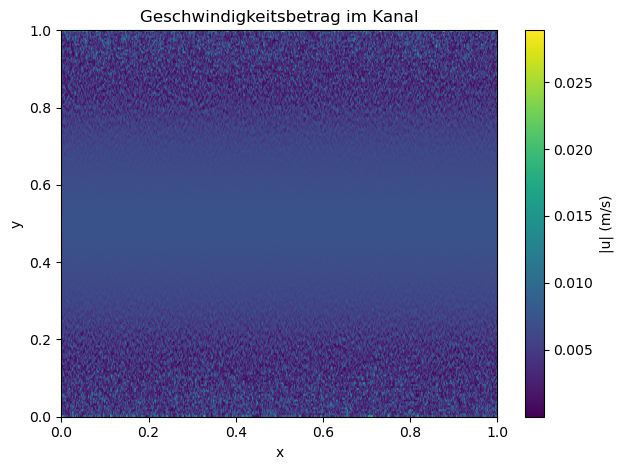

In [3]:

# --- 🧱 Lattice & Einheiten ---
lattice = Lattice(D2Q9, device="cuda", dtype=dtype)

flow = lt.ChannelFlow2D(
    resolution_x=res_x,
    resolution_y=res_y,
    reynolds_number=Re,
    mach_number=Mach,
    lattice=lattice,
    char_length_lu=res_y
)

# --- 🧱 Wände definieren ---
x, y = flow.grid  # physikalische Gitterkoordinaten

# y in LU umrechnen (nur nötig, falls du nach physikalischen Einheiten schneiden willst)
# Hier reicht aber die Indexierung direkt, da wir die äußersten Zeilen meinen:
mask = np.zeros_like(x, dtype=bool)
mask[:, 0] = True           # untere Wand (y=0)
mask[:, -1] = True          # obere Wand (y=max)

# Maske setzen
flow.mask = mask

# --- 🌀 Forcing (Guo) ---
from lettuce.force import Guo  # dein Guo-Code
forcing = Guo(lattice, tau=flow.units.relaxation_parameter_lu, acceleration=acceleration)

# --- 🔁 Setup Simulation ---
if collision_operator == "BGK":
    collision=lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu, force = forcing)
elif collision_operator == "KBC":
    collision=lt.KBCCollision2D(lattice, tau=flow.units.relaxation_parameter_lu)

streaming = StandardStreaming(lattice)
simulation = Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

# --- 📊 Beobachter ---
Energy = IncompressibleKineticEnergy(lattice, flow)
reporter = lt.ObservableReporter(Energy, interval=100, out=None)
simulation.reporters.append(reporter)

# ... (Deine anderen Reporter in der 2D-Simulation) ...

wq = WallQuantities(lattice,flow,averaging_steps = 1)
reporter2 = lt.ObservableReporter(wq, interval=100, out=None)
simulation.reporters.append(reporter2)
# ... (Starte deine 2D-Simulation) ...

steps = int(flow.units.convert_time_to_lu(tmax))

vtk_reporter = lt.VTKReporter(
    lattice=lattice,
    flow=flow,
    interval= max(1,int(steps/100)),                    # alle 100 Zeitschritte ein VTK-Frame
    filename_base=basedir + "/output" # Basisname der Dateien
)
simulation.reporters.append(vtk_reporter)

simulation.initialize_f_neq

# --- ▶️ Simulation starten ---
steps = int(flow.units.convert_time_to_lu(tmax))  # z.B. 5 Sekunden

mlups = simulation.step(num_steps=steps)
# --- 📈 Analyse ---
u = lattice.u(simulation.f) # u-Komponente
u_mean= torch.mean(u, dim=(1,0))

print(u) # Mittelung über x-Richtung

# Hole u_x-Komponente (Index 0)
u_numpy = u.cpu().numpy()  # [2, res_x, res_y]
u_mag = np.sqrt(u_numpy[0]**2 + u_numpy[1]**2)  # Geschwindigkeitbetrag

plt.imshow(u_mag.T, origin='lower', extent=[0, 1, 0, 1], aspect='auto')
plt.colorbar(label='|u| (m/s)')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Geschwindigkeitsbetrag im Kanal")
plt.tight_layout()
plt.show()

wq = np.array(simulation.reporters[1].out)
Energy = np.array(simulation.reporters[0].out)

with open(csvdir + 'Energy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(Energy)
with open(csvdir + 'WallQuantities.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(wq)

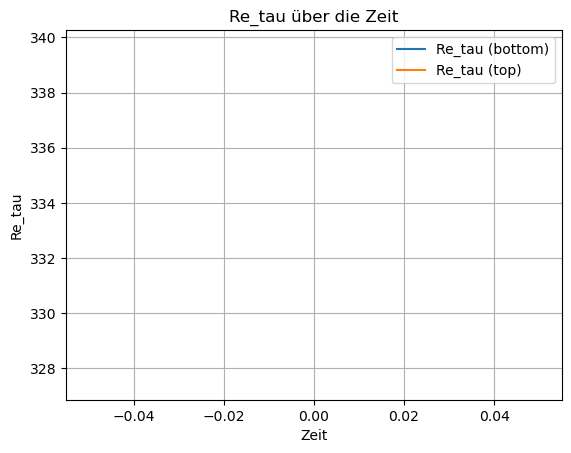

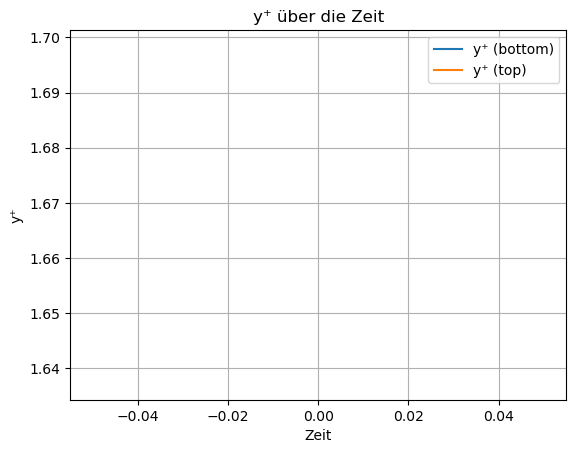

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Beispiel: Daten laden
data = wq
time = data[:, 1]
re_tau_bottom = data[:, 2]
y_plus_bottom = data[:, 3]
re_tau_top = data[:, 4]
y_plus_top = data[:, 5]

plt.figure()
plt.plot(time, re_tau_bottom, label="Re_tau (bottom)")
plt.plot(time, re_tau_top, label="Re_tau (top)")
plt.xlabel("Zeit")
plt.ylabel("Re_tau")
plt.legend()
plt.grid()
plt.title("Re_tau über die Zeit")
plt.show()

plt.figure()
plt.plot(time, y_plus_bottom, label="y⁺ (bottom)")
plt.plot(time, y_plus_top, label="y⁺ (top)")
plt.xlabel("Zeit")
plt.ylabel("y⁺")
plt.legend()
plt.grid()
plt.title("y⁺ über die Zeit")
plt.show()
